In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.io # Used to load the OCTAVE *.mat files
import scipy.misc # Used to show matrix as an image
import matplotlib.cm as cm # Used to display images in a specific colormap
import random # To pick random images to display

from scipy.special import expit # Vectorized sigmoid function

### 1. Multiclass Classification

#### 1.1 Dataset

In [6]:
datafile = '/Users/chaitanyagupta/Desktop/machine-learning/Neural_Network/ex3/ex3data1.mat'

mat = scipy.io.loadmat( datafile )

X, y = mat['X'], mat['y']

# Insert a column of 1's to X as usual

X = np.insert(X,0,1,axis=1)

print("'y' shape: %s. ", mat['y'].shape)
print("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))

# X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
# y is a classification for each image. 1-10, where "10" is the handwritten "0"


'y' shape: %s.  (5000, 1)
'X' shape: (5000, 401). X[0] shape: (401,)


#### 1.2 Vizualizing the data

In [7]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
            
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
        
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

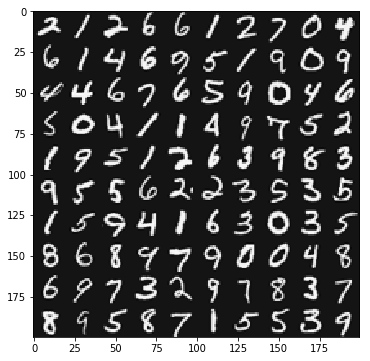

In [8]:
displayData()

#### 1.3 Vectorizing Logistic Regression

In [9]:
# Sigmoid Function
def g(z):
    return (1 / (1 + np.exp(-z)))


# Cost Function
def J(theta, X, y, lambdaa = 0.):
    
    m = X.shape[0]
    
    hypothesis  = g(np.dot(X, theta)).reshape(m, 1)
    
    term1 =  np.dot(np.log(hypothesis), -y.T)  # shape: (5000,5000)
    
    term2 = np.dot(np.log(1 - hypothesis), (1 - y.T)) #s hape: (5000,5000)
    
    left_hand = (term1 - term2) / m  # shape: (5000,5000)
    
    right_hand = theta.T.dot( theta ) + (lambdaa / (2 * m))
    
    return left_hand + right_hand


# theta = np.zeros(401)

# error = J(theta, X, y, lambdaa = 0)

# print(error)


#### 1.4 One vs All Classification

In [10]:
def gradient(theta, X, y, lambdaa = 0.):
    
    m = X.shape[0]
    
    hypo = g(np.dot(X, theta)) - y   # shape: (5000,5000)
    
    # Regularization skips the first element in theta
    regterm = theta[1:] * (lambdaa / m) # shape: (400,1)
    
    regterm = regterm.reshape(regterm.size, 1)  #shape: (400,1)
    
    grad = (1 / m) * np.dot(X.T, hypo) # shape: (401, 5000)
    # Regularization skips the first element in theta
    
    grad[1:] = grad[1:] + regterm
    
    return grad # shape: (401, 5000)


# theta = np.zeros(401)

# error = gradient(theta, X, y, lambdaa = 0)


In [11]:
from scipy import optimize

def optimizeTheta(theta,X,y,lambdaa=0.):
    result = optimize.fmin_cg(J, fprime=gradient, x0=theta, \
                              args=(X, y, lambdaa), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [12]:
def buildTheta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta function where each row corresponds
    to the learned logistic regression params for one class
    """
    lambdaa = 0.
    
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)  # shape: (401,)
    
    Theta = np.zeros((10,X.shape[1]))  # shape: (10, 401)
    
    for i in range(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        
        print("Optimizing for handwritten number %d..."%i)
        
        logic_Y = np.array([1 if x == iclass else 0 for x in y]).reshape((X.shape[0],1)) # shape: (5000, 1)
        
        itheta, imincost = optimizeTheta(initial_theta,X,logic_Y,lambdaa)
        
        Theta[i,:] = itheta
        
    print("Done!")
    return Theta

In [13]:
Theta = buildTheta()

Optimizing for handwritten number 0...


ValueError: shapes (401,5000) and (401,5000) not aligned: 5000 (dim 1) != 401 (dim 0)

In [ ]:
def predictOneVsAll(myTheta,myrow):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = [10] + list(range(1,10))
    hypots  = [0]*len(classes)

    # Compute a hypothesis for each possible outcome
    # Choose the maximum hypothesis to find result
    
    for i in range(len(classes)):
        hypots[i] = g(np.dot(myTheta[i],myrow))
    return classes[np.argmax(np.array(hypots))]

In [ ]:

# "You should see that the training set accuracy is about 94.9%"# "You s 

n_correct, n_total = 0., 0.
incorrect_indices = []

for irow in range(X.shape[0]):
    n_total += 1

    
    if predictOneVsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: 
        incorrect_indices.append(irow)

print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

# Neural Networks

## 2.1 Model Representation

In [15]:
# You have been provided with a set of network parameters (Θ(1),Θ(2)) 
# already trained by us. These are stored in ex3weights.mat
datafile = '/Users/chaitanyagupta/Desktop/machine-learning/Neural_Network/ex3/ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print("Theta1 has shape:",Theta1.shape)
print("Theta2 has shape:",Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


## 2.2 Feedforward Propogation

In [26]:
def propagateForward(row, Thetas):
    """
    Function that given a list of Thetas, propagates the
    Row of features forwards, assuming the features already
    include the bias unit in the input layer, and the 
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1) # Add the bias unit
        features = a


def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,11)
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [27]:
# "You should see that the accuracy is about 97.5%"
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []

# Loop over all of the rows in X (all of the handwritten images)
# and predict what digit is written. Check if it's correct, and
# compute an efficiency.

for irow in range(X.shape[0]):
    n_total += 1
    
    if predictNN(X[irow],myThetas) == int(y[irow]): 
        n_correct += 1
    else:
        incorrect_indices.append(irow)
        
print("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 97.5%


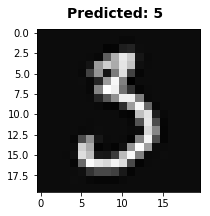

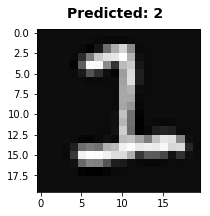

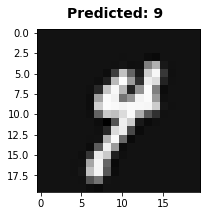

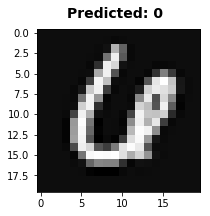

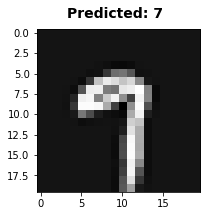

In [29]:
# Pick some of the images we got WRONG and look at them, just to see
for x in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( getDatumImg(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')